In [1]:
%matplotlib inline
import pandas as pd
import cvxportfolio as cp

Download the problem data with `yfinance`. We select five liquid stocks.

In [3]:
import yfinance
tickers = ["AMZN", "AAPL", "MSFT", "GOOGL", "TSLA", "GM"]
# start_date = "2012-01-01"
# end_date = "2016-12-31"
returns = pd.DataFrame(
    dict(
        [
            (
                ticker,
                yfinance.download(ticker)[ #, start_date=start_date, end_date=end_date)[
                    "Adj Close"
                ].pct_change(),
            )
            for ticker in tickers
        ]
    )
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
returns.describe()

,AMZN,AAPL,MSFT,GOOGL,TSLA,GM
count,6517.000000,10669.000000,9343.000000,4691.000000,3216.000000,3116.000000
mean,0.001706,0.001098,0.001135,0.000986,0.002129,0.000337
std,0.036087,0.028218,0.021317,0.019436,0.036149,0.021823
min,-0.247661,-0.518692,-0.301159,-0.116341,-0.210628,-0.173228
25%,-0.013282,-0.013071,-0.009216,-0.007988,-0.015603,-0.010450
50%,0.000402,0.000000,0.000351,0.000750,0.001218,0.000293
75%,0.014799,0.014705,0.011357,0.010077,0.019390,0.010891
max,0.344714,0.332280,0.195653,0.199915,0.243951,0.199432


We get the return on cash from FRED.

In [5]:
import pandas_datareader

returns[["USDOLLAR"]] =  pandas_datareader.get_data_fred("DFF", start='2000-01-01') / (250 * 100)
returns = returns.fillna(method="ffill").dropna()

returns.tail()

,AMZN,AAPL,MSFT,GOOGL,TSLA,GM,USDOLLAR
Date,,,,,,,
2023-04-03,-0.008520,0.007702,-0.003711,0.006073,-0.061168,-0.011178,0.000193
2023-04-04,0.015038,-0.003250,-0.000174,0.003450,-0.011244,-0.014613,0.000193
2023-04-05,-0.027417,-0.011290,-0.009889,-0.002387,-0.036660,-0.018187,0.000193
2023-04-06,0.009496,0.005496,0.025533,0.037810,-0.002480,-0.014249,0.000193
2023-04-10,0.001078,-0.015972,-0.007579,-0.018262,-0.002972,0.032957,0.000193


We compute rolling estimates of the first and second moments of the returns using a window of 1000 days. We shift them by one unit (so at every day we present the optimizer with only past data).

In [6]:
r_hat = returns.rolling(window=1000).mean().shift(1).dropna()
Sigma_hat = returns.shift(1).rolling(window=1000).cov().dropna()

r_hat

,AMZN,AAPL,MSFT,GOOGL,TSLA,GM,USDOLLAR
Date,,,,,,,
2014-11-11,0.000831,0.001098,0.000840,0.000741,0.002726,0.000125,0.000004
2014-11-12,0.000850,0.001112,0.000845,0.000756,0.002727,0.000130,0.000004
2014-11-13,0.000815,0.001104,0.000842,0.000750,0.002642,0.000138,0.000004
2014-11-14,0.000843,0.001133,0.000882,0.000760,0.002617,0.000170,0.000004
2014-11-17,0.000826,0.001126,0.000872,0.000737,0.002619,0.000167,0.000004
...,...,...,...,...,...,...,...
2023-04-03,0.000376,0.001465,0.001121,0.000758,0.003376,0.000381,0.000048
2023-04-04,0.000368,0.001473,0.001112,0.000753,0.003317,0.000360,0.000048
2023-04-05,0.000382,0.001468,0.001111,0.000753,0.003311,0.000349,0.000048


In [7]:
Sigma_hat

AMZN          AAPL          MSFT         GOOGL   
Date                                                                          
2014-11-11 AMZN      4.227103e-04  9.088484e-05  9.413298e-05  1.419049e-04  \
           AAPL      9.088484e-05  2.778230e-04  6.723849e-05  9.196142e-05   
           MSFT      9.413298e-05  6.723849e-05  1.940881e-04  8.280250e-05   
           GOOGL     1.419049e-04  9.196142e-05  8.280250e-05  2.311543e-04   
           TSLA      1.997852e-04  1.247740e-04  1.100183e-04  1.431737e-04   
...                           ...           ...           ...           ...   
2023-04-10 MSFT      3.277049e-04  3.414957e-04  4.119100e-04  3.407461e-04   
           GOOGL     3.211572e-04  3.156128e-04  3.407461e-04  4.379395e-04   
           TSLA      4.525649e-04  4.705029e-04  4.168661e-04  3.821365e-04   
           GM        2.146339e-04  2.658744e-04  2.499809e-04  2.721064e-04   
           USDOLLAR -1.922229e-08 -1.408872e-08  6.908463e-09 -1.717695e-08   

                             TSLA            GM      USDOLLAR  
Date                                                           
2014-11-11 AMZN      1.997852e-04  1.347603e-04  1.758145e-10  
           AAPL      1.247740e-04  1.019410e-04 -1.168518e-09  
           MSFT      1.100183e-04  1.143526e-04 -8.994653e-10  
           GOOGL     1.431737e-04  1.161227e-04 -3.422907e-10  
           TSLA      1.282414e-03  1.828980e-04 -7.148170e-10  
...                           ...           ...           ...  
2023-04-10 MSFT      4.168661e-04  2.499809e-04  6.908463e-09  
           GOOGL     3.821365e-04  2.721064e-04 -1.717695e-08  
           TSLA      1.853911e-03  4.660275e-04 -1.131960e-07  
           GM        4.660275e-04  8.001688e-04 -4.005382e-08  
           USDOLLAR -1.131960e-07 -4.005382e-08  3.246069e-09  

[14812 rows x 7 columns]

For the cash return instead we simply use the previous day's return.

In [8]:
r_hat['USDOLLAR'] = returns['USDOLLAR'].shift(1)

Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

In [9]:
tcost_model = cp.TcostModel(half_spread=10e-4)
hcost_model = cp.HcostModel(borrow_costs=1e-4)

We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [22]:
risk_model = cp.FullCovariance(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 1.0, 1.0, 1.0
leverage_limit = cp.LeverageLimit(3)

spo_policy = cp.SinglePeriodOpt(
    return_forecast=r_hat,
    costs=[
        gamma_risk * risk_model,
        gamma_trade * tcost_model,
        gamma_hold * hcost_model,
    ],
    constraints=[leverage_limit],
)

We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

In [23]:
# simulator = cp.MarketSimulator(adia.Universe('US_medium'))

# #policies = [adia.BlackLitterman1(...), adia.BlackLitterman2(...), ...]

# policies = []
# for parameter1 in [...]:
#     for parameter2 in [...]:
#         policies.append(policy(parameter1, parameter2))


# simulator.run_multiple_backtests(policies, start_time="2020-01-01")



In [24]:
# simulator = cp.MarketSimulator(adia.Universe('US_medium'))

# policies = [adia.BlackLitterman1(...), adia.BlackLitterman2(...), ...]

# simulator.run_multiple_backtests(policies, start_time="2020-01-01")



In [25]:
market_sim = cp.MarketSimulator(
    returns, [tcost_model, hcost_model], cash_key="USDOLLAR"
)
init_portfolio = pd.Series(index=returns.columns, data=250000.0)
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(
    init_portfolio,
    start_time="2020-01-01",
    end_time="2023-04-01",
    policies=[spo_policy, 
             cp.Hold()
            ],
)
results[0].summary()

Number of periods                               818
Initial timestamp               2020-01-02 00:00:00
Final timestamp                 2023-03-31 00:00:00
Portfolio return (%)                         61.307
Excess return (%)                            60.305
Excess risk (%)                              65.824
Sharpe ratio                                  0.917
Max. drawdown                                71.474
Turnover (%)                                 36.209
Average policy time (sec)                     0.008
Average simulator time (sec)                  0.001


The total value of the portfolio in time.

In [26]:
results[1].summary()

Number of periods                               818
Initial timestamp               2020-01-02 00:00:00
Final timestamp                 2023-03-31 00:00:00
Portfolio return (%)                         37.156
Excess return (%)                            36.153
Excess risk (%)                              43.350
Sharpe ratio                                  0.834
Max. drawdown                                58.318
Turnover (%)                                  0.000
Average policy time (sec)                     0.000
Average simulator time (sec)                  0.001


<Axes: >

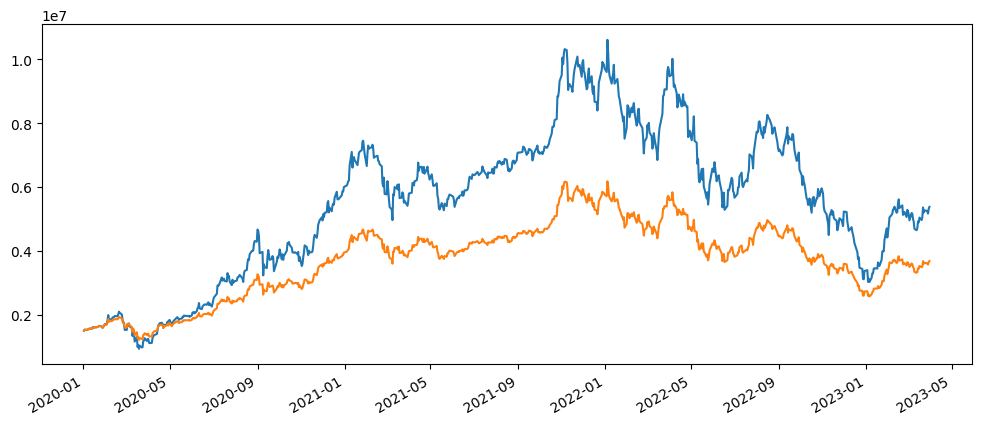

In [27]:
results[0].v.plot(figsize=(12, 5))
results[1].v.plot(figsize=(12, 5))

The weights vector of the portfolio in time.

<Axes: >

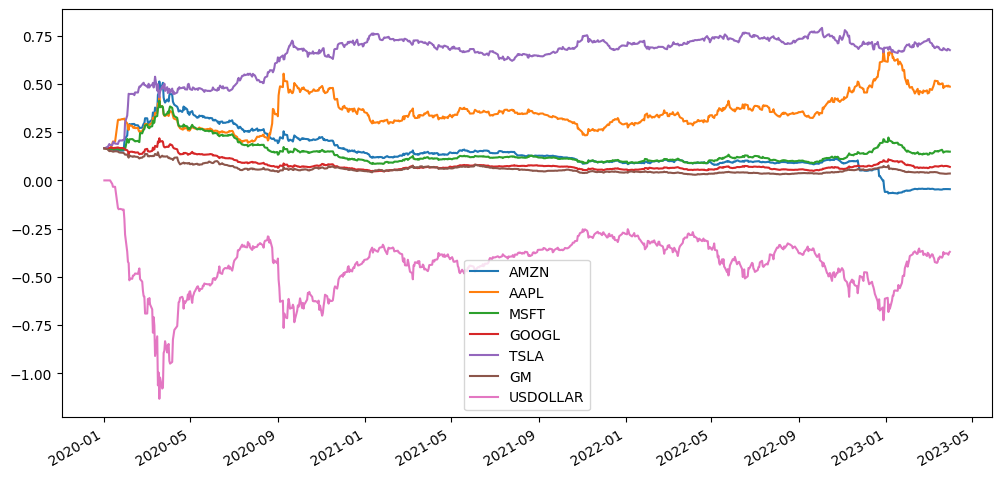

In [28]:
results[0].w.plot(figsize=(12, 6))